# Make sure to have an environment running and pip install . in the PyWGCNA directory to set everything up

In [1]:
# !sudo apt-get install libcairo2-dev libjpeg-dev libgif-dev
%pip install pycairo
%pip install python-igraph
%pip install GEOparse
%pip install py2cytoscape
%pip install anndata
import anndata
import pandas as pd
import cairo
import igraph as ig
import matplotlib.pyplot as plt
import GEOparse
import PyWGCNA
import py2cytoscape
from py2cytoscape.data.cyrest_client import CyRestClient
import numpy as np
import scipy.stats, pylab, math
import statsmodels.sandbox.stats.multicomp

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Load differentially expressed genes between pre and post bed-rest groups
### Data downloaded from: https://www.ncbi.nlm.nih.gov/geo/geo2r/?acc=GSE104999

In [2]:
GSE_diffexpressed = pd.read_csv("./GSE104999.top.table.tsv", delimiter="\t")
GSE_diffexpressed

,ID,adj.P.Val,P.Value,t,B,logFC,GB_ACC,SPOT_ID
0,16736628,0.000102,1.900000e-09,9.025627,10.40144,1.320000e+00,NM_003476,NaN
1,16982921,0.000354,1.320000e-08,8.163041,8.87372,2.180000e+00,NaN,TCONS_00009856-XLOC_004270
2,16951191,0.000533,2.980000e-08,7.813354,8.21816,1.350000e+00,NM_005677,NaN
3,16857068,0.000717,5.350000e-08,7.565791,7.74143,2.280000e+00,NM_170678,NaN
4,16844294,0.000729,6.800000e-08,7.465247,7.54484,8.700000e-01,NM_021724,NaN
...,...,...,...,...,...,...,...,...
53612,16656811,0.999988,1.000000e+00,0.000106,-5.90967,2.730000e-05,NaN,--normgene->intron
53613,16937090,0.999988,1.000000e+00,0.000078,-5.90967,7.870000e-06,NaN,TCONS_l2_00019759-XLOC_l2_009616
53614,16860808,0.999988,1.000000e+00,-0.000062,-5.90967,-6.170000e-06,NaN,TCONS_00027518-XLOC_013045
53615,16708987,0.999990,1.000000e+00,-0.000036,-5.90967,-3.800000e-06,NaN,TCONS_00017862-XLOC_008601


In [3]:
# Get less than < 0.05 adjusted p value for diff expressed data
GSE_diffexpressed_lowp = GSE_diffexpressed[GSE_diffexpressed['adj.P.Val'] < 0.05]
GSE_diffexpressed_lowp

,ID,adj.P.Val,P.Value,t,B,logFC,GB_ACC,SPOT_ID
0,16736628,0.000102,1.900000e-09,9.025627,10.40144,1.320,NM_003476,NaN
1,16982921,0.000354,1.320000e-08,8.163041,8.87372,2.180,NaN,TCONS_00009856-XLOC_004270
2,16951191,0.000533,2.980000e-08,7.813354,8.21816,1.350,NM_005677,NaN
3,16857068,0.000717,5.350000e-08,7.565791,7.74143,2.280,NM_170678,NaN
4,16844294,0.000729,6.800000e-08,7.465247,7.54484,0.870,NM_021724,NaN
...,...,...,...,...,...,...,...,...
93,16820398,0.046260,8.140000e-05,-4.674624,1.50996,-1.050,NM_001076785,NaN
94,16726311,0.046260,8.200000e-05,4.672201,1.50440,0.481,NM_001243733,NaN
95,16733150,0.047889,8.570000e-05,-4.655037,1.46501,-0.272,NM_001144874,NaN
96,16943577,0.048988,8.920000e-05,-4.639919,1.43032,-0.886,NaN,ENST00000363491


## Get GSE Data for pre and post sample groups

In [4]:
# If you don't have the soft.gz file
# gse = GEOparse.get_GEO(geo="GSE104999", destdir="./")

# If you have the soft.gz file
gse = GEOparse.get_GEO(filepath="./GSE104999_family.soft.gz")

19-Mar-2023 21:37:41 INFO GEOparse - Parsing ./GSE104999_family.soft.gz: 
19-Mar-2023 21:37:41 DEBUG GEOparse - DATABASE: GeoMiame
19-Mar-2023 21:37:41 DEBUG GEOparse - SERIES: GSE104999
19-Mar-2023 21:37:41 DEBUG GEOparse - PLATFORM: GPL17692
19-Mar-2023 21:38:13 DEBUG GEOparse - SAMPLE: GSM2813727
19-Mar-2023 21:38:13 DEBUG GEOparse - SAMPLE: GSM2813728
19-Mar-2023 21:38:14 DEBUG GEOparse - SAMPLE: GSM2813729
19-Mar-2023 21:38:14 DEBUG GEOparse - SAMPLE: GSM2813730
19-Mar-2023 21:38:14 DEBUG GEOparse - SAMPLE: GSM2813731
19-Mar-2023 21:38:14 DEBUG GEOparse - SAMPLE: GSM2813732
19-Mar-2023 21:38:14 DEBUG GEOparse - SAMPLE: GSM2813733
19-Mar-2023 21:38:14 DEBUG GEOparse - SAMPLE: GSM2813734
19-Mar-2023 21:38:14 DEBUG GEOparse - SAMPLE: GSM2813735
19-Mar-2023 21:38:15 DEBUG GEOparse - SAMPLE: GSM2813736
19-Mar-2023 21:38:15 DEBUG GEOparse - SAMPLE: GSM2813737
19-Mar-2023 21:38:15 DEBUG GEOparse - SAMPLE: GSM2813738
19-Mar-2023 21:38:15 DEBUG GEOparse - SAMPLE: GSM2813739
19-Mar-2023 21:

In [5]:
gene_matrix = pd.DataFrame({})

for gsm_name, gsm in gse.gsms.items():
    sample_title = ''
    for key, value in gsm.metadata.items():
        if key == 'title':
            sample_title = value[0]
            break
        
    data = {"ID_REF" : gsm.table['ID_REF'], sample_title : gsm.table['VALUE'], }
    curr_matrix = pd.DataFrame(data).set_index('ID_REF')
    
    gene_matrix = pd.concat([gene_matrix, curr_matrix], axis=1)


# Contains data for pre and post groups and genes
post_gene_matrix = gene_matrix.filter(regex='Post$', axis=1)
pre_gene_matrix = gene_matrix.filter(regex='Pre$', axis=1)
print(post_gene_matrix)

            S1_Post    S2_Post    S3_Post    S4_Post    S5_Post    S6_Post  \
ID_REF                                                                       
16650001   1.337836   1.191963   0.841217   1.988995   0.743551   1.323006   
16650003   0.687227   1.081627   0.665508   2.292052   1.361903   0.660462   
16650005   3.026331   0.583696   0.872767   0.987338   1.433827   0.720881   
16650007   1.170054   0.775640   1.517638   0.863007   2.364895   1.011600   
16650009   0.608450   0.910207   0.680500   0.384329   0.722352   0.278435   
...             ...        ...        ...        ...        ...        ...   
17127713   3.411501   2.930730   3.365940   2.922846   3.802899   3.271720   
17127715  12.170301  12.030650  12.216695  12.175753  12.149571  12.224201   
17127717   3.275734   3.259497   2.707728   3.420640   3.523639   3.509721   
17127719  11.960605  11.740504  11.909211  11.897991  11.952244  11.690005   
17127721   3.845676   3.580950   3.202263   3.956928   4.218122 

## Compute correlation coefficient

In [6]:
top_diff_expr_genes = GSE_diffexpressed_lowp['ID']
post_top_diff_expr = post_gene_matrix.filter(items=top_diff_expr_genes, axis=0)
post_top_diff_expr_values = post_top_diff_expr.values
pearson_corr_top_diffexpr = np.corrcoef(post_top_diff_expr_values)
pd.DataFrame(pearson_corr_top_diffexpr, index = post_top_diff_expr.index, columns = post_top_diff_expr.index)

ID_REF,16736628,16982921,16951191,16857068,16844294,16939718,16909775,16909760,16823255,16679064,...,16651329,16846687,16825638,16918953,16722075,16820398,16726311,16733150,16943577,16854088
ID_REF,,,,,,,,,,,,,,,,,,,,,
16736628,1.000000,0.144627,0.180335,0.064000,-0.377160,-0.064666,0.144107,-0.137831,0.202112,-0.262810,...,0.131063,0.019312,0.284576,-0.198540,0.273673,0.652082,-0.467908,-0.128275,0.373760,-0.427830
16982921,0.144627,1.000000,0.434931,-0.007930,0.343894,-0.138495,0.281555,0.495451,0.139355,0.212290,...,0.165845,0.151295,-0.184372,-0.059365,0.395895,0.170549,-0.286438,0.157792,0.101286,-0.217619
16951191,0.180335,0.434931,1.000000,0.000861,-0.034093,-0.548597,-0.074727,0.182798,-0.386471,0.038694,...,-0.283995,0.289945,0.332865,-0.018438,0.311753,0.170578,-0.449341,-0.156716,0.018596,-0.000330
16857068,0.064000,-0.007930,0.000861,1.000000,0.052454,0.608211,-0.357591,-0.125083,0.584028,0.003385,...,0.297372,0.258857,-0.160056,0.274114,-0.449249,0.056633,-0.163302,0.318230,-0.042373,-0.320012
16844294,-0.377160,0.343894,-0.034093,0.052454,1.000000,0.120033,0.516460,0.642719,0.221990,0.119960,...,-0.086012,0.187435,-0.027114,-0.144620,-0.240911,0.035403,0.150726,0.089734,-0.048882,-0.420278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16820398,0.652082,0.170549,0.170578,0.056633,0.035403,-0.105331,0.560546,-0.071696,0.096819,-0.108429,...,-0.322113,0.330879,0.465611,-0.043431,-0.091836,1.000000,-0.638166,-0.598401,-0.075421,-0.686538
16726311,-0.467908,-0.286438,-0.449341,-0.163302,0.150726,0.433928,-0.390144,-0.181193,-0.012928,0.404486,...,0.070327,-0.459599,-0.425749,0.053092,-0.193081,-0.638166,1.000000,0.294068,-0.106416,0.056099
16733150,-0.128275,0.157792,-0.156716,0.318230,0.089734,0.453739,-0.220322,0.235040,0.272232,0.122506,...,0.602314,-0.154240,-0.431659,-0.232612,0.301650,-0.598401,0.294068,1.000000,0.468949,0.274567


In [7]:
np.fill_diagonal(pearson_corr_top_diffexpr, 0)
pearson_corr_top_diffexpr = np.multiply(pearson_corr_top_diffexpr, 
                                          np.tri(*pearson_corr_top_diffexpr.shape))

In [8]:
inds_correl_above_thresh = np.where(pearson_corr_top_diffexpr >= 0.75)
cor_coeff_values_above_thresh = pearson_corr_top_diffexpr[inds_correl_above_thresh]

In [9]:
z_scores = 0.5*np.log((1 + cor_coeff_values_above_thresh)/ (1 - cor_coeff_values_above_thresh))
z_scores

array([0.98366119, 1.00233815, 1.13887936, 1.03356482, 1.33852922,
       1.19924723, 0.98071809, 1.04995164, 0.98385985, 1.05766606,
       1.09502572, 1.04925701, 1.53185475, 1.08685508, 1.23496671,
       1.00489465, 1.01617725, 0.99634141, 1.03769541, 1.09544771,
       1.0066695 , 0.9793592 , 1.0268236 , 1.00435616, 1.0641527 ,
       0.98536488, 1.21064941, 1.46276139, 1.11926322, 1.09261987,
       1.01147512, 1.03563085, 0.98672973, 1.11986658, 0.98173921])

In [10]:
M = post_top_diff_expr_values.shape[1]
P_values = 2*scipy.stats.norm.cdf(-np.abs(z_scores)*math.sqrt(M-3))
P_values_adj = statsmodels.sandbox.stats.multicomp.multipletests(P_values, method="fdr_bh")[1]
len(np.where(P_values_adj >= 0.01)[0])
P_values_adj

array([0.00330254, 0.00330254, 0.00299359, 0.00330254, 0.00069181,
       0.00187245, 0.00330254, 0.00330254, 0.00330254, 0.00330254,
       0.00299359, 0.00330254, 0.00015105, 0.00299359, 0.0018504 ,
       0.00330254, 0.00330254, 0.00330254, 0.00330254, 0.00299359,
       0.00330254, 0.00330254, 0.00330254, 0.00330254, 0.00330254,
       0.00330254, 0.00187245, 0.00019993, 0.00299359, 0.00299359,
       0.00330254, 0.00330254, 0.00330254, 0.00299359, 0.00330254])

In [11]:
gene_index = post_top_diff_expr.index
row_col_inds_tuple_list = list(zip(gene_index[inds_correl_above_thresh[0]], 
                                   gene_index[inds_correl_above_thresh[1]]))
row_col_inds_tuple_list

[(17088230, 16883074),
 (16846543, 16883074),
 (16970132, 16757051),
 (16848318, 16803469),
 (16905528, 16970132),
 (16809645, 16803469),
 (16713187, 16919072),
 (16848264, 16848318),
 (16790360, 16899271),
 (16937152, 16987076),
 (16912965, 17088230),
 (17001879, 17088230),
 (17001879, 16846543),
 (17001879, 16937152),
 (16765998, 17088230),
 (16765998, 17073565),
 (16765998, 17001879),
 (16736120, 17058878),
 (16886677, 16791898),
 (16812168, 16683493),
 (17124692, 17121832),
 (16857913, 16982921),
 (16857913, 16857919),
 (17109758, 16752542),
 (16691023, 17073565),
 (16691023, 17012036),
 (16707503, 17118704),
 (16820398, 17121832),
 (16820398, 17124692),
 (16820398, 17109758),
 (16726311, 16912965),
 (16733150, 16846543),
 (16733150, 17118704),
 (16733150, 17001879),
 (16854088, 16707503)]

In [12]:
final_network = ig.Graph.TupleList(row_col_inds_tuple_list, vertex_name_attr='label')
final_network.summary()

'IGRAPH U--- 41 35 -- \n+ attr: label (v)'

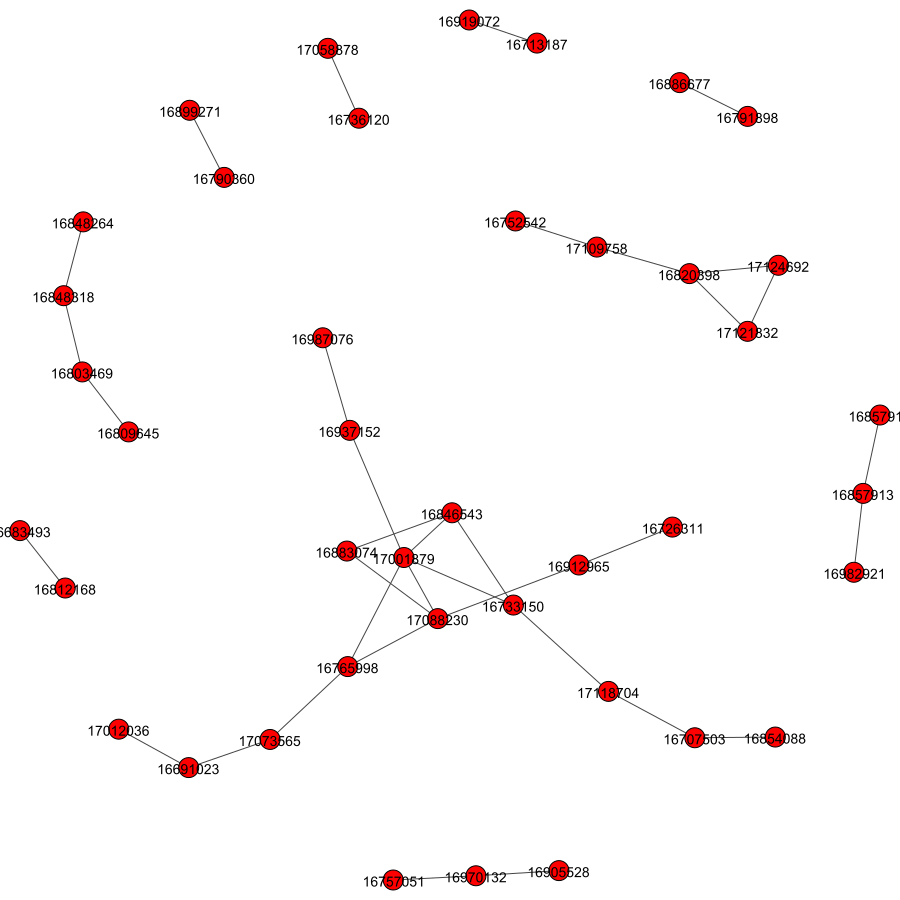

In [13]:
ig.drawing.plot(final_network, bbox=(900, 900))

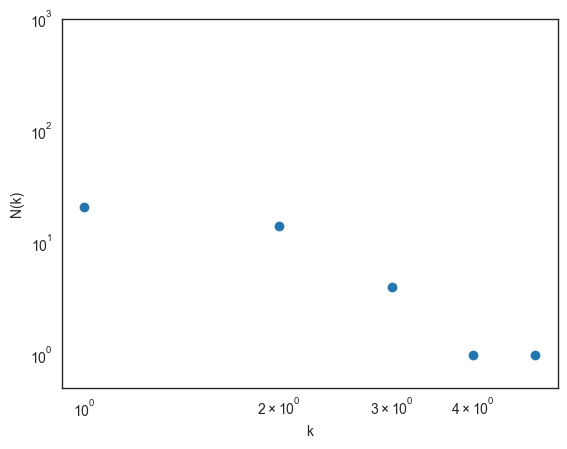

In [50]:
degree_dist = final_network.degree_distribution()
xs, ys = zip(*[(left, count) for left, _, count in degree_dist.bins()])
plt.scatter(xs, ys, marker="o")
ax = plt.gca()
ax.set_yscale("log")
ax.set_xscale("log")
plt.ylim((0.5,1000))
pylab.xlabel("k")
pylab.ylabel("N(k)")
pylab.show()

In [14]:
ig.statistics.power_law_fit(final_network.degree()).alpha

3.676410193238329

# Figuring out Centralities with PyWGCNA

In [20]:
# Transpose post gene matrix for PyWGCNA
pt_gene_matrix = post_gene_matrix.T
cols = pt_gene_matrix.columns.tolist()
index = pt_gene_matrix.index.tolist()
post_data = pd.DataFrame(pt_gene_matrix.values, columns=cols)
post_data['ID'] = index
post_data.set_index('ID', inplace=True)
post_data

,16650001,16650003,16650005,16650007,16650009,16650011,16650013,16650015,16650017,16650019,...,17127703,17127705,17127707,17127709,17127711,17127713,17127715,17127717,17127719,17127721
ID,,,,,,,,,,,,,,,,,,,,,
S1_Post,1.337836,0.687227,3.026331,1.170054,0.608450,1.270306,2.610821,3.824779,2.774028,2.111921,...,9.101577,2.937852,10.825916,3.493770,10.933420,3.411501,12.170301,3.275734,11.960605,3.845676
S2_Post,1.191963,1.081627,0.583696,0.775640,0.910207,0.669329,4.109890,3.364679,1.773608,2.363704,...,8.689821,2.948848,10.672797,3.372085,10.645352,2.930730,12.030650,3.259497,11.740504,3.580950
S3_Post,0.841217,0.665508,0.872767,1.517638,0.680500,0.824226,2.321099,3.690005,2.431985,3.668598,...,8.941926,2.489344,10.905398,3.405125,10.946862,3.365940,12.216695,2.707728,11.909211,3.202263
S4_Post,1.988995,2.292052,0.987338,0.863007,0.384329,2.104405,2.496536,3.102666,1.611268,0.432708,...,8.980821,2.830840,10.876616,3.324438,10.930274,2.922846,12.175753,3.420640,11.897991,3.956928
S5_Post,0.743551,1.361903,1.433827,2.364895,0.722352,0.917261,3.119815,2.970281,0.822260,1.554313,...,9.197503,2.247015,10.987658,3.621288,10.964240,3.802899,12.149571,3.523639,11.952244,4.218122
S6_Post,1.323006,0.660462,0.720881,1.011600,0.278435,0.976911,2.609391,4.004685,1.754463,0.922684,...,8.913736,2.169847,10.738756,3.440399,10.825354,3.271720,12.224201,3.509721,11.690005,3.235236
S7_Post,1.225548,1.119646,0.674943,1.221934,0.446859,0.464283,1.345994,4.471181,2.505273,4.595736,...,9.162814,2.781822,10.883569,3.946674,10.858113,3.141313,12.199453,3.575975,11.962989,4.059276
S9_Post,0.987055,0.665958,1.723987,1.104811,1.612450,0.772145,4.294373,2.801994,1.396968,2.231695,...,9.303169,2.874233,10.859925,3.069109,10.947780,3.317229,12.111077,3.311843,11.848047,4.301576
S11_Post,1.058880,1.190795,1.454066,0.691766,0.698691,1.201766,2.463151,3.483550,1.658446,0.938234,...,8.802103,2.793106,10.260514,3.426883,10.533261,3.161030,11.974494,2.909508,11.715061,3.976177


In [21]:
# Transpose post gene matrix for PyWGCNA
pt_gene_matrix = pre_gene_matrix.T
cols = pt_gene_matrix.columns.tolist()
index = pt_gene_matrix.index.tolist()
pre_data = pd.DataFrame(pt_gene_matrix.values, columns=cols)
pre_data['ID'] = index
pre_data.set_index('ID', inplace=True)
pre_data

,16650001,16650003,16650005,16650007,16650009,16650011,16650013,16650015,16650017,16650019,...,17127703,17127705,17127707,17127709,17127711,17127713,17127715,17127717,17127719,17127721
ID,,,,,,,,,,,,,,,,,,,,,
S1_Pre,0.774729,0.259190,1.851694,0.938033,0.619654,1.365100,2.106888,3.161351,3.024022,0.942651,...,9.339778,3.372047,10.881988,3.887358,10.971956,3.838408,12.242559,3.329556,11.931899,4.551171
S2_Pre,0.674861,1.625214,0.797562,0.661179,0.730898,0.817180,3.323255,4.078087,0.640275,2.499396,...,9.313456,2.812058,10.844579,3.547709,10.991054,3.637423,12.223962,3.461216,11.841158,4.009352
S3_Pre,0.778501,0.687557,1.751475,1.476813,0.875444,0.767610,4.215452,3.270454,2.018581,1.059237,...,9.057031,3.234185,10.770625,3.781389,10.787749,3.264917,12.162111,3.475689,11.885002,3.863551
S4_Pre,1.626518,0.778608,1.213658,1.506582,0.536280,2.256019,2.761531,2.881482,1.487202,4.018904,...,8.967238,2.745656,10.668215,3.234590,10.815127,3.338705,12.022053,3.475689,11.792465,4.570711
S5_Pre,0.681241,1.645073,2.469082,0.836076,0.922844,1.993563,3.379743,3.636854,0.966448,0.674580,...,9.158684,3.553917,10.911688,3.687288,10.761236,3.838743,12.101762,3.833607,11.821292,3.498966
S6_Pre,1.354079,0.951284,1.692375,0.607542,0.505873,0.518991,3.185218,3.079839,3.353074,3.308496,...,9.220926,2.842415,10.686110,3.353041,10.955488,3.427495,12.226024,3.327096,11.980740,3.920813
S7_Pre,0.277320,0.563118,3.774744,0.780026,0.560030,0.751373,3.070672,2.748180,0.929441,0.598406,...,9.071137,3.018991,10.659652,3.348223,10.698285,3.340961,12.083253,3.158979,11.610447,3.377691
S9_Pre,1.407868,0.954195,0.869354,0.929811,1.566398,0.407857,2.084606,3.628544,1.975372,1.259567,...,9.101504,2.692064,10.756988,3.091719,10.673401,3.310727,12.161904,3.458222,11.736937,4.002197
S11_Pre,3.509227,2.194994,1.781549,0.942672,0.979410,0.805526,3.945633,4.062944,2.279727,2.266682,...,8.838070,2.808670,10.711498,3.690917,10.619429,3.442439,12.022996,3.291066,11.827601,4.086446


In [22]:
pypost = PyWGCNA.WGCNA(name="Post-Data", 
              geneExp = post_data)
pypre = PyWGCNA.WGCNA(name="Pre-Data", 
              geneExp = pre_data)

Pre-processing...
	Detecting genes and samples with too many missing values...
	Done pre-processing..

Run WGCNA...
pickSoftThreshold: calculating connectivity for given powers...
will use block size  845


KeyboardInterrupt: 

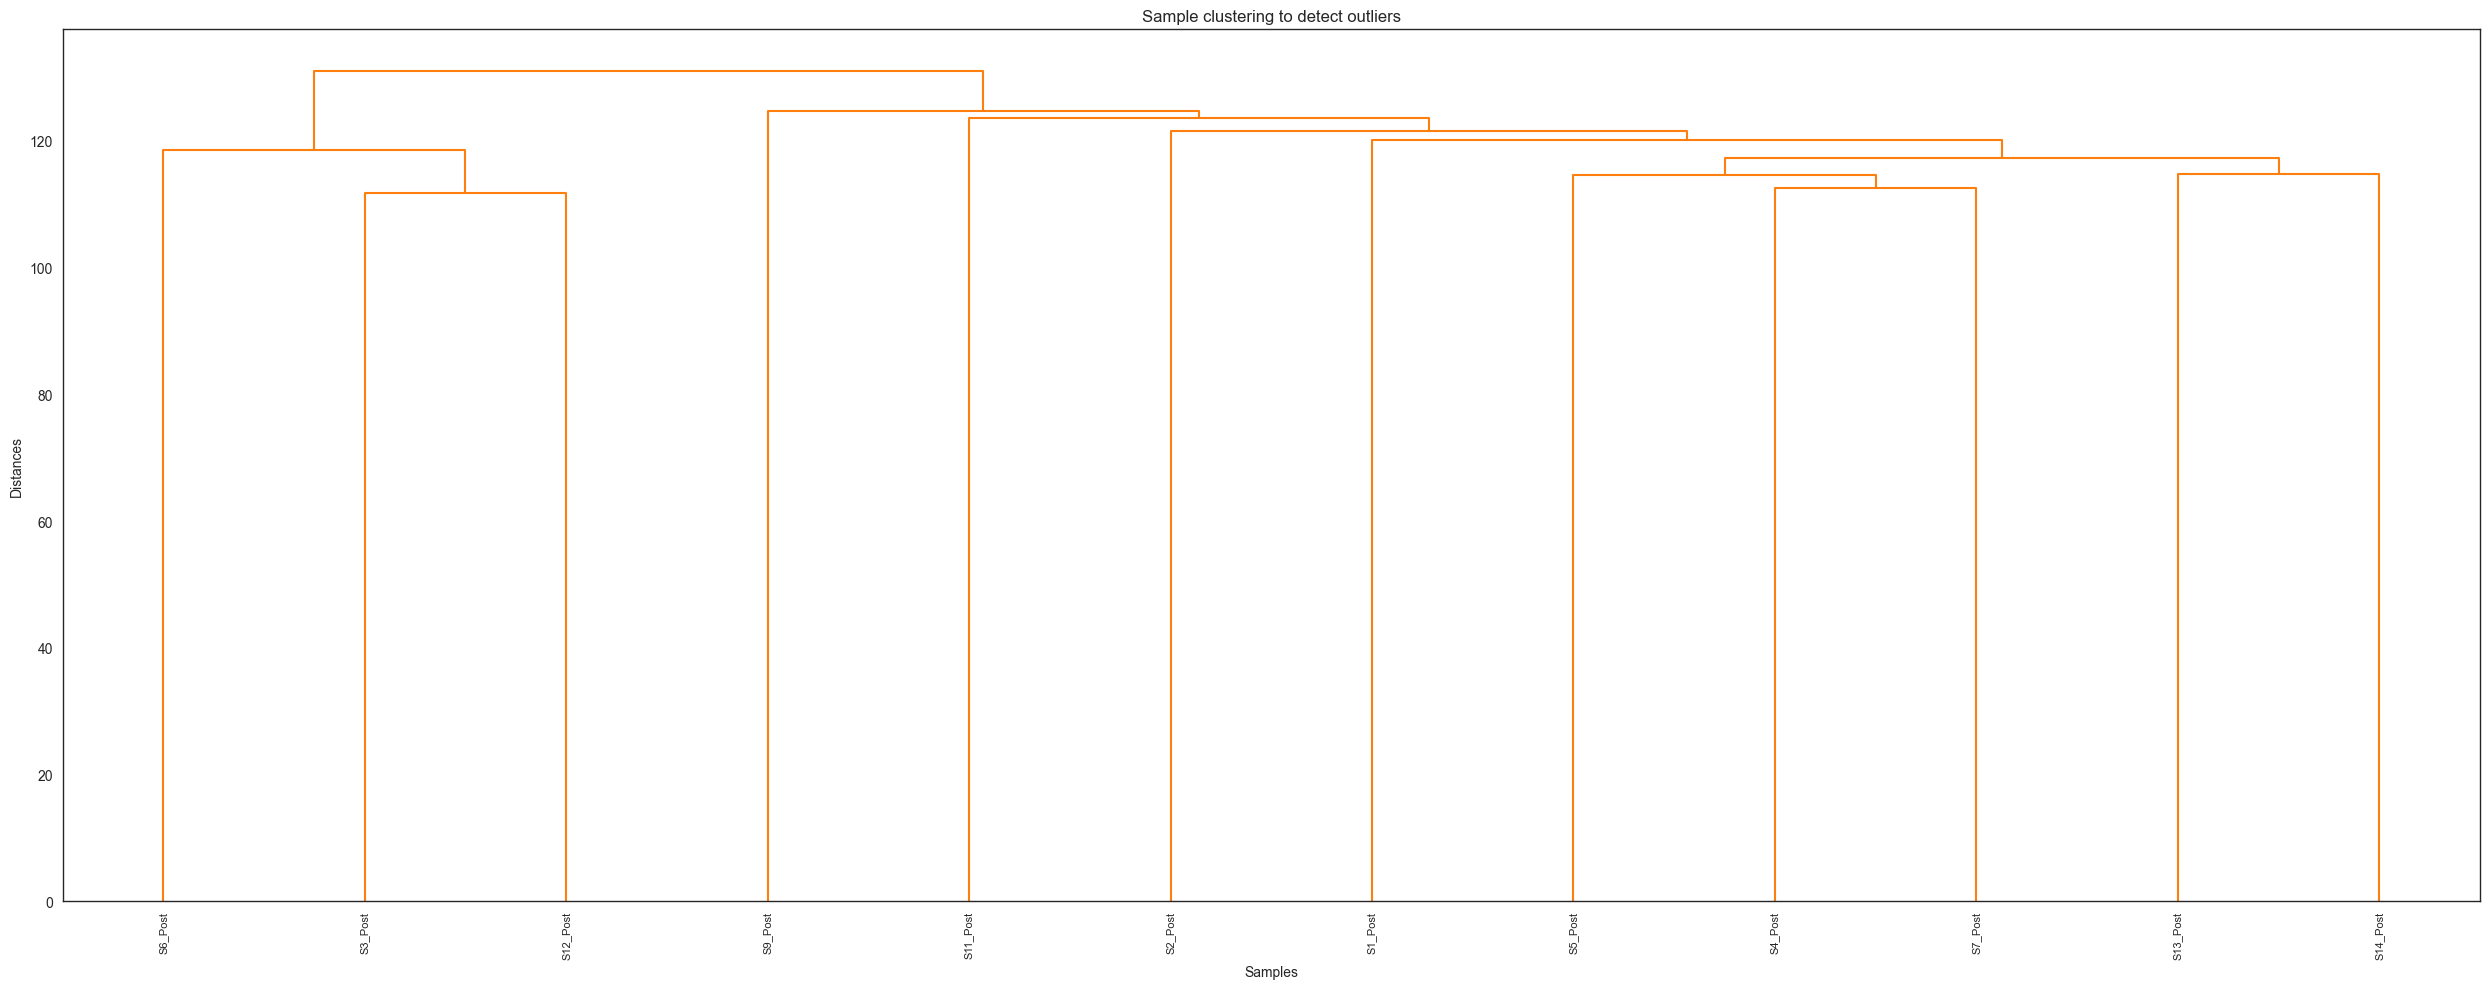

In [33]:
pypost.runWGCNA()